# Classification - Final Project

### Predicting 10-Year Risk of Heart Disease, Using 4 Independent Classifiers & an Ensemble Model

In [201]:
#import packages
#data manipulation and visuals packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib
import warnings
import itertools
from pylab import rcParams
from sklearn.linear_model import LinearRegression

import skillsnetwork
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#classificaiton associated packages
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score, confusion_matrix, accuracy_score, roc_auc_score, classification_report, f1_score
from sklearn.preprocessing import label_binarize, StandardScaler, MinMaxScaler, LabelBinarizer, LabelEncoder, OrdinalEncoder;

The Heart Risk dataset was downloaded from Kaggle (https://www.kaggle.com/), and is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD). The dataset contains:
* +4000 records
* 15 attributes, all potential risk factors (demographic, behavioral, medical, and target heart disease risk variable)
    * demographic: sex, age
    * behavioral: current smoker status, cigarettes per day, 
    * medical (history): blood pressure medications, prevalent stroke, prevalent hypertension, diabetes
    * medical (current): total cholesterol, systolic blood pressure, diastolic blood pressure, BMI, heart rate, glucose
    * target variable: 10-year CHD risk (coronary heart disease)

In [202]:
#load dataset and preview
path = "/Users/.../"
data = pd.read_csv(path+'Heart Disease Data.csv')

pd.set_option('display.max_columns', None)
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [203]:
#Asess data missingness
data.isna().sum();

Because we have a decent amount of missing data, we will create 2 datasets:
* A complete dataset with no missing values
* An imputed dataset with the following logic:
    * Continous and missing variables: use mean imputation
    * Categorical and missing variables: use most frequent/ modal imputation

In [204]:
df_complete = data.dropna()

In [205]:
#creating the imputed dataset, df_imputed
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
most_freq_imp = SimpleImputer(strategy="most_frequent")

continous_missing = ['cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']
categorical_missing = ['education', 'BPMeds']

df_imputed = data
#mean imputation
for i in continous_missing:
    df_imputed[i] = mean_imp.fit_transform(df_imputed[i].values.reshape(-1, 1))[:, 0]

#most frequent imputation
for i in categorical_missing:
    df_imputed[i] = most_freq_imp.fit_transform(df_imputed[i].values.reshape(-1, 1))[:, 0]

#check missingness of data
df_imputed.isna().sum();

In [206]:
#Dataset Summaries
table = [
    ('Original Data', data.shape[0]),
    ('Complete Data - No NaNs', df_complete.shape[0]),
    ('Imputed Data - Mean and Modal Imputation', df_imputed.shape[0])
]
table_cols = ['Dataset', 'Number of Rows']
pd.DataFrame(table, columns=table_cols)

,Dataset,Number of Rows
0,Original Data,4238
1,Complete Data - No NaNs,3656
2,Imputed Data - Mean and Modal Imputation,4238


In [207]:
#identify binary, categorical and numeric values - Using the complete dataset
#Identify unique values per columns
features_df = df_complete[df_complete.columns.difference(['TenYearCHD'])]
target_variable = ['TenYearCHD']
data_variable_types = pd.DataFrame([[i, len(features_df[i].unique())] for i in features_df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')

binary_variables = list(data_variable_types[data_variable_types['Unique Values'] == 2].index)
categorical_variables = list(data_variable_types[(data_variable_types['Unique Values'] <= 6) & (data_variable_types['Unique Values'] > 2)].index)

continous_variables = list(set(features_df.columns) - set(categorical_variables) - set(binary_variables))

In [208]:
#Summary Statistics for our datasets, primarily focusing on continous variables
#Complete dataset
df_complete[continous_variables].describe()
df_complete[binary_variables].describe()

#Imputed dataset
df_imputed[continous_variables].describe()
df_imputed[binary_variables].describe();

In [221]:
#Plot Correlation matrices using both datasets
def correlation_matrices(j):
    corr = j.corr()
    return corr.style.background_gradient(cmap='coolwarm').set_precision(2)

correlation_matrices(df_complete)
#correlation_matrices(df_imputed)



,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.00,-0.02,0.02,0.21,0.33,-0.05,-0.00,0.00,0.01,-0.07,-0.05,0.05,0.07,-0.11,0.00,0.09
age,-0.02,1.00,-0.16,-0.21,-0.19,0.13,0.05,0.31,0.11,0.27,0.39,0.21,0.14,-0.00,0.12,0.23
education,0.02,-0.16,1.00,0.03,0.01,-0.01,-0.03,-0.08,-0.04,-0.01,-0.12,-0.06,-0.14,-0.06,-0.03,-0.06
currentSmoker,0.21,-0.21,0.03,1.00,0.77,-0.05,-0.04,-0.11,-0.04,-0.05,-0.13,-0.12,-0.16,0.05,-0.05,0.02
cigsPerDay,0.33,-0.19,0.01,0.77,1.00,-0.05,-0.04,-0.07,-0.04,-0.03,-0.09,-0.06,-0.09,0.06,-0.05,0.05
BPMeds,-0.05,0.13,-0.01,-0.05,-0.05,1.00,0.11,0.26,0.05,0.09,0.27,0.20,0.11,0.01,0.05,0.09
prevalentStroke,-0.00,0.05,-0.03,-0.04,-0.04,0.11,1.00,0.07,0.01,0.01,0.06,0.06,0.04,-0.02,0.02,0.05
prevalentHyp,0.00,0.31,-0.08,-0.11,-0.07,0.26,0.07,1.00,0.08,0.17,0.70,0.62,0.30,0.15,0.09,0.18
diabetes,0.01,0.11,-0.04,-0.04,-0.04,0.05,0.01,0.08,1.00,0.05,0.10,0.05,0.09,0.06,0.61,0.09
totChol,-0.07,0.27,-0.01,-0.05,-0.03,0.09,0.01,0.17,0.05,1.00,0.22,0.17,0.12,0.09,0.05,0.09


The dataset, has mostly, for binary and categorical variables been processed. As such, we will focus on scaling our variables, using both MinMax Scaler, and Standard Scaler (for continuous varibales, and education, which is an ordinal variable).

The 4 classifiers of interest will be:
* Logisitc Regression
* KNN
* Support Vector Machines
* Decision Tree

and the Ensemble Model utilized will be Stacked Classifier, all across 2 datasets, i.e., MixMax scaled and StandardSclaler scaled datasets, for both complete and imputed datasets.

We will conduct hyperparamter tuning by making use of gridsearchcv (elbow curves for KNN) to optimize all models and select for the best parameters, making use of the complete/ non-imputed dataset since it has fewer data points.

In [209]:
#2 non-imputed datasets of interest, by scaling alternatives, which we will use for all our gridsearch hyperparamter tuning
min_max_scaled_df = df_complete
standard_scaler_scaled_df = df_complete

#Scalers and variables to be scaled
#MinMax Scaling
min_max_scaler = MinMaxScaler()
variables_for_min_max_scaling = [continous_variables+['education']]

for column in variables_for_min_max_scaling:
    min_max_scaled_df[column] = min_max_scaler.fit_transform(min_max_scaled_df[column])

#Standard Scaling
standard_scaler = StandardScaler()
variables_for_standard_scaling = [continous_variables]

for column in variables_for_standard_scaling:
    standard_scaler_scaled_df[column] = standard_scaler.fit_transform(standard_scaler_scaled_df[column])

#Create data splits
#Train-Test data split
y_mm, X_mm = min_max_scaled_df['TenYearCHD'], min_max_scaled_df.drop(columns='TenYearCHD')
y_ss, X_ss = standard_scaler_scaled_df['TenYearCHD'], standard_scaler_scaled_df.drop(columns='TenYearCHD')
# Split the data into training and test samples
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_mm, y_mm, test_size=0.3)
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_ss, y_ss, test_size=0.3)

## Hyperparameter Tuning
### K-Nearest Neighbors

<Figure size 1800x1200 with 0 Axes>

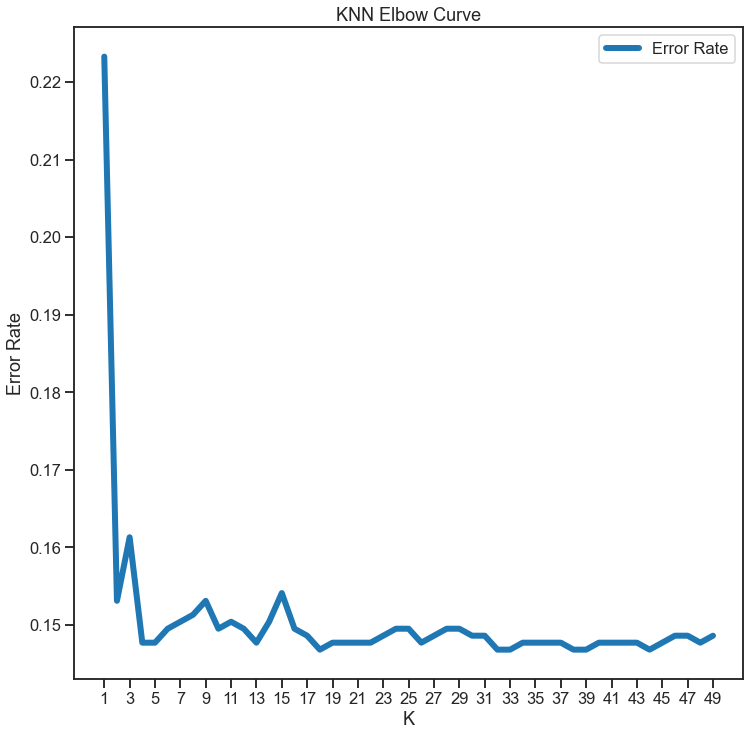

In [211]:
def knn_elbow_curve_plotter(train_data_x, train_data_y, test_data_x, test_data_y):
    max_k = 50
    error_rates = list() # 1-accuracy

    for k in range(1, max_k):
        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn = knn.fit(train_data_x, train_data_y)
        
        y_pred = knn.predict(test_data_x)
        error = 1-round(accuracy_score(test_data_y, y_pred), 4)
        error_rates.append((k, error))

    error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

    # Plot Accuracy (Error Rate) results
    sns.set_context('talk')
    sns.set_style('ticks')

    plt.figure(dpi=300)
    ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
    ax.set(xlabel='K', ylabel='Error Rate')
    ax.set_xticks(range(1, max_k, 2))
    plt.title('KNN Elbow Curve');

#knn_elbow_curve_plotter(X_train_mm, y_train_mm, X_test_mm, y_test_mm) #k = 9
knn_elbow_curve_plotter(X_train_ss, y_train_ss, X_test_ss, y_test_ss) #k = 14

Using our Elbow Curve for KNN, we see that for:
* Min Max scaled data, the most optimal k = 9
* Standard Scaler scaled data, the most optimal k = 14

### Support Vector Machine

In [212]:
def svm_hyperparameter_tuning(train_data_x, train_data_y):
    # defining parameter range
    parameter_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']}

    grid = GridSearchCV(svm.SVC(), parameter_grid, refit = True, verbose = 3)

    # fitting the model for grid search
    grid.fit(train_data_x, train_data_y)
    print('Best parameters: ', grid.best_params_)
    print("Training Accuracy :",grid.best_score_)


#svm_hyperparameter_tuning(X_train_mm, y_train_mm) #Best parameters:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
#svm_hyperparameter_tuning(X_train_ss, y_train_ss) #Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Using GridSearchCV for our Support VEctor Machine, we see that the best parameters for:
* Min Max scaled data: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
* Standard Scaler scaled data: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

### Decision Tree Classifier

In [213]:
def decision_tree_hyperparameter_tuning(train_data_x, train_data_y):
    # defining parameter range
    parameter_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(1, 10),
        'min_samples_split': range(2, 10),
        'min_samples_leaf': range(1, 5)
    }

    grid = GridSearchCV(DecisionTreeClassifier(), parameter_grid, cv = 10, verbose = 1, n_jobs = 1)

    # fitting the model for grid search
    grid.fit(train_data_x, train_data_y)
    print('Best parameters: ', grid.best_params_)
    print("Training Accuracy :",grid.best_score_)

#decision_tree_hyperparameter_tuning(X_train_mm, y_train_mm) #{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
#decision_tree_hyperparameter_tuning(X_train_ss, y_train_ss) # {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5}

Using GridSearchCV for our Decision Tree Classifier, we see that the best parameters for:
* Min Max scaled data: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
* Standard Scaler scaled data: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5}

## Fitting our final models

In [214]:
def min_max_scaled_pipeline(df):
    #scale dataframe 
    min_max = MinMaxScaler()
    variables_for_scaling = [continous_variables+['education']]

    for column in variables_for_scaling:
        df[column] = min_max.fit_transform(df[column])

    #Train-Test data split
    y, X = df['TenYearCHD'], df.drop(columns='TenYearCHD')
    # Split the data into training and test samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #initiate all regressors
    lr = LogisticRegression().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_neighbors = 9).fit(X_train, y_train)
    svm_r = svm.SVC(C = 10, gamma = 0.01, kernel = 'rbf').fit(X_train, y_train)
    dt_r = DecisionTreeClassifier(criterion = 'gini',max_depth = 3, min_samples_leaf = 1, min_samples_split = 3).fit(X_train, y_train)
    stacked_classifier = StackingCVClassifier(classifiers=[lr,svm_r,dt_r], meta_classifier= lr, random_state=42).fit(X_train, y_train)


    #5 predictions sets
    y_pred_lr = lr.predict(X_test)
    y_pred_knn = knn.predict(X_test)
    y_pred_svm = svm_r.predict(X_test)
    y_pred_dt = dt_r.predict(X_test)
    y_pred_sc = stacked_classifier.predict(X_test)


    #tabulate accuracy and f1 scores scores for different regressors
    table = [
        ('Logistic', round(100*accuracy_score(y_test, y_pred_lr), 2)),
        ('KNN (k = 9)', round(100*accuracy_score(y_test, y_pred_knn), 2)),
        ('Support Vector Machine', round(100*accuracy_score(y_test, y_pred_svm), 2)),
        ('Decision Tree', round(100*accuracy_score(y_test, y_pred_dt), 2)),
        ('StackingCVC Classifier', round(100*accuracy_score(y_test, y_pred_sc), 2))
    ]

    table_cols = ['Regressor', 'Accuracy Score']

    return pd.DataFrame(table, columns = table_cols)

In [215]:
def standardscaler_scaled_pipeline(df):
    #scale dataframe 
    std_scaler = StandardScaler()
    variables_for_scaling = [continous_variables]

    for column in variables_for_scaling:
        df[column] = std_scaler.fit_transform(df[column])

    #Train-Test data split
    y, X = df['TenYearCHD'], df.drop(columns='TenYearCHD')
    # Split the data into training and test samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #initiate all regressors
    lr = LogisticRegression().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_neighbors = 14).fit(X_train, y_train)
    svm_r = svm.SVC(C = 100, gamma = 0.01, kernel = 'rbf').fit(X_train, y_train)
    dt_r = DecisionTreeClassifier(criterion = 'gini',max_depth = 4, min_samples_leaf = 1, min_samples_split = 5).fit(X_train, y_train)
    stacked_classifier = StackingCVClassifier(classifiers=[lr,svm_r,dt_r], meta_classifier= lr, random_state=42).fit(X_train, y_train)


    #5 predictions sets
    y_pred_lr = lr.predict(X_test)
    y_pred_knn = knn.predict(X_test)
    y_pred_svm = svm_r.predict(X_test)
    y_pred_dt = dt_r.predict(X_test)
    y_pred_sc = stacked_classifier.predict(X_test)


    #tabulate accuracy and f1 scores scores for different regressors
    table = [
        ('Logistic', round(100*accuracy_score(y_test, y_pred_lr), 2)),
        ('KNN (k = 14)', round(100*accuracy_score(y_test, y_pred_knn), 2)),
        ('Support Vector Machine', round(100*accuracy_score(y_test, y_pred_svm), 2)),
        ('Decision Tree', round(100*accuracy_score(y_test, y_pred_dt), 2)),
        ('StackingCVC Classifier', round(100*accuracy_score(y_test, y_pred_sc), 2))
    ]

    table_cols = ['Regressor', 'Accuracy Score']

    return pd.DataFrame(table, columns = table_cols)

Our final accuracy score dataframe for all the models across our datasets (scaled differently) is below:

In [216]:

frames = [min_max_scaled_pipeline(df_complete), standardscaler_scaled_pipeline(df_complete), min_max_scaled_pipeline(df_imputed), standardscaler_scaled_pipeline(df_imputed)]
pd.concat(frames).reset_index(drop = True)

,Regressor,Accuracy Score
0,Logistic,84.69
1,KNN (k = 9),83.87
2,Support Vector Machine,84.14
3,Decision Tree,83.96
4,StackingCVC Classifier,84.50
5,Logistic,84.59
6,KNN (k = 14),84.23
7,Support Vector Machine,83.96
8,Decision Tree,83.68
9,StackingCVC Classifier,84.50


From the accuracy scores, we can see that the best perfoming scenario was:
* Dataset: mean and frequency imputed dataset
* Classifier: Logistic regression, with an accuracy score of 0.86 (86.08%)

# Summary Insights

## Main Objective
* The goal was to create a model that can best predict 10-Year risk of heart disease using the ongoing Framingham Heart Study Data, sourced from Kaggle

## Data Exploration
### Dataset processing
Given the availability of missing data (13.7%), I created 2 datasets:
* Complete data: where all rows with a missing value were dropped
* Imputed data: which had the following algorithm for variables
    * if binary, the impute with most frequent value
    * if continuous, impute with mean value

### Summary Statistics
#### Using Complete Data (all NaNs removed)
Continuous (Means):
* Age: 49.6 years, cigarettes per day: 9, Glucose: 81.9 mg/dL, Total cholesterol: 236.9 mg/dL, BMI: 25.8, Heart rate: 75.7 beats per minute, Systolic BP: 132.4 mm Hg, Diastolic BP: 82.9 mm Hg
Binary (Proportions):
* Male: 44.4%, Current Smoker: 48.9%, Diabetic: 2.7%, Prevalent Hypertension: 31.2%, Prevalent Stroke: 0.6%

#### Using Imputed Data (mean and most frequent imputation)
Continuous (Means):
* Age: 49.6 years, cigarettes per day: 9, Glucose: 82.0 mg/dL, Total cholesterol: 236.8 mg/dL, BMI: 25.8, Heart rate: 75.9 beats per minute, Systolic BP: 132.4 mm Hg, Diastolic BP: 82.9 mm Hg
Binary (Proportions):
* Male: 42.9%, Current Smoker: 49.4%, Diabetic: 2.6%, Prevalent Hypertension: 31.1%, Prevalent Stroke: 0.6%

## Models
### Variable Preparation, and Models Used
In order to train our models, we made use of the complete data. We made use of 2 scaling methods:
* Min Max Scaling
* Standard Scaling, applied primarily to continuous variables

This resulted in 2 sets of training datasets, which were:
* Complete data, with min max scaling
* Complete data, with standard scaling

4 classifiers, and an ensemble model were used:
* Classifiers: Logistic Regression, KNN, Support Vector Machine and Decision Trees
* Ensemble: Stacking Classifier

All models were trained on the 2 complete datasets above. GridsearchCV was used to tune hyperparameters for KNN, Support Vector Machine and Decision Tree classifiers, and elbow curves were used to find the optimal k for the KNN classifier.

### Recommended Model
From the accuracy scores, we can see that the best performing scenario was:
* Dataset: mean and frequency imputed dataset
* Classifier: Logistic regression, with an accuracy score of 0.86 (86.08%) 

## Next Steps
To better improve the model, other next steps include:
* Consider other imputation methods such as median value, and using predictions (linear for continuous and binary classifiers for binary variables) to impute values
* Consider new features such as:
    * Creating categorical variables from continuous variables, such as age (pediatric vs adult), glucose (low, medium, high), BMI (underweight, healthy, overweight, obese) and seeing their impact on model performance
    * Feature engineering to introduce interaction, polynomial and exponential terms
* Hyperparameter tuning using the imputed dataset (which has more information)
* Considering other classifiers and ensemble models such as Naive Bayes, XGBoost, Random Forest, and Neural Networks

### References

WHO Fact Sheet (Cardiovascular Diseases)
http://www.who.int/mediacentre/factsheets/fs317/en/

Data Source References
https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset/data